In [1]:
#checking what device is being used

import tensorflow as tf
print(tf.test.gpu_device_name())


/device:GPU:0


In [2]:
# importing modules

import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from keras import backend as K
from keras import layers, losses
from keras import regularizers
import scipy
from scipy import io

#setting seaborn style
sns.set(style='whitegrid', context='notebook')

random_seed=4


Using TensorFlow backend.


In [3]:
# loading the mat file

# ********** loading 802.11ac file *****************
# wifi_data_ac_16=scipy.io.loadmat('80211ac_5packets_16qam.mat')['waveStruct']['waveform'][0][0]
# wifi_data_ac_16=wifi_data_ac_16.T
# wifi_data_ac_16=wifi_data_ac_16.flatten()

# wifi_data_ac_64=scipy.io.loadmat('80211ac_5packets.mat')['waveStruct']['waveform'][0][0]
# wifi_data_ac_64=wifi_data_ac_64.T
# wifi_data_ac_64=wifi_data_ac_64.flatten()

# wifi_data_ac_256=scipy.io.loadmat('80211ac_5packets_256qam.mat')['waveStruct']['waveform'][0][0]
# wifi_data_ac_256=wifi_data_ac_256.T
# wifi_data_ac_256=wifi_data_ac_256.flatten()

# ************ loading 802.11ax file **************

# wifi_data_ax_16=scipy.io.loadmat('80211ax_10packets_16qam.mat')['waveStruct']['waveform'][0][0]
# wifi_data_ax_16=wifi_data_ax_16.T
# wifi_data_ax_16=wifi_data_ax_16.flatten()

wifi_data_ax_64=scipy.io.loadmat('80211ax_10packets.mat')['waveStruct']['waveform'][0][0]
wifi_data_ax_64=wifi_data_ax_64.T
wifi_data_ax_64=wifi_data_ax_64.flatten()

# wifi_data_ax_256=scipy.io.loadmat('80211ax_10packets_256qam.mat')['waveStruct']['waveform'][0][0]
# wifi_data_ax_256=wifi_data_ax_256.T
# wifi_data_ax_256=wifi_data_ax_256.flatten()


#wifi_data_numpy=np.concatenate((wifi_data_ax_16,wifi_data_ax_64,wifi_data_ax_256,wifi_data_ac_16,wifi_data_ac_64,wifi_data_ac_256))

#wifi_data_numpy=np.concatenate((wifi_data_ax_64,wifi_data_ac_64))

wifi_data_numpy=wifi_data_ax_64

wifi_data=pd.DataFrame({'real':np.real(wifi_data_numpy),'img':np.imag(wifi_data_numpy),
                       'phase':np.angle(wifi_data_numpy), 'amp':np.abs(wifi_data_numpy),
                      })

# because some rows are 0, I'm removing them

wifi_data=wifi_data.loc[~(wifi_data==0).any(axis=1)]
wifi_data['label']=1
wifi_data.reset_index(drop=True, inplace=True)
wifi_data.head()

,real,img,phase,amp,label
0,-0.080651,0.196699,1.959912,0.212591,1
1,-1.132706,0.020009,3.123930,1.132883,1
2,-0.115224,-0.671572,-1.740715,0.681385,1
3,1.220895,-0.108197,-0.088390,1.225680,1
4,1.220895,-0.108197,-0.088390,1.225680,1


In [4]:
# loading recorded LTE data

lte_data_numpy=np.fromfile('usrp_lte.csv', dtype=np.complex64, count=500000)

lte_data_numpy=lte_data_numpy*100

lte_data=pd.DataFrame({'real':np.real(lte_data_numpy)[:],'img':np.imag(lte_data_numpy)[:],
                        'phase':np.angle(lte_data_numpy)[:], 'amp':np.abs(lte_data_numpy)[:],
                       })


# because some rows are 0, I'm removing them

lte_data=lte_data.loc[~(lte_data==0).any(axis=1)]
lte_data['label']=0
#lte_data=lte_data.sample(frac=1)
lte_data.reset_index(drop=True, inplace=True)
lte_data.head()

,real,img,phase,amp,label
0,0.018311,0.015259,0.694738,0.023836,0
1,-0.042726,-0.012207,-2.863293,0.044436,0
2,0.006104,-0.003052,-0.463648,0.006824,0
3,0.076296,0.009156,0.119429,0.076844,0
4,0.024415,0.003052,0.124355,0.024605,0


In [5]:
# creating train and test data. Wifi is our clean data and LTE is anomalous data.

training_size = 350000

# train data. dropping labels on training data since we don't need it for training
x_train = lte_data[:training_size].drop(['label'], axis=1)

# test data
x_test=lte_data[training_size:]

# inserting Wi-Fi data in between
# x_test.iloc[15000:25000] = wifi_data.iloc[:10000].values
# x_test.iloc[25000:35000] = wifi_data.iloc[20000:30000].values
# x_test.iloc[35000:45000] = wifi_data.iloc[40000:50000].values
# x_test.iloc[70000:80000] = wifi_data.iloc[60000:70000].values
# x_test.iloc[80000:90000] = wifi_data.iloc[70000:80000].values
# x_test.iloc[90000:100000] = wifi_data.iloc[80000:90000].values

#x_test.iloc[30000:60000] = wifi_data.iloc[:30000].values

x_test.iloc[45000:60000] = wifi_data.iloc[:15000].values



print("Length of train data:",len(x_train))
print("Length of test data:",len(x_test))
print("Length of Wi-Fi data:",60000)

Length of train data: 350000
Length of test data: 125173
Length of Wi-Fi data: 60000


C:\Users\sidav\anaconda3\envs\gpu-env\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [6]:
# creating training and validation dataset
x_train,x_validate = train_test_split(x_train,test_size=0.2,random_state=random_seed)

# separating labels from test dataset for plotting later
x_test,labels = x_test.drop('label',axis=1).values,x_test.label.values

In [7]:
# creating a pipeline for normalizing

pipeline=Pipeline([('normalizer',Normalizer()), ('scaler',MinMaxScaler())])

x_train_transformed=pipeline.fit_transform(x_train)
x_validate_transformed=pipeline.fit_transform(x_validate)
x_test_transformed=pipeline.transform(x_test)

In [8]:
# Reshaping data for LSTM

x_train_transformed=x_train_transformed.reshape(x_train_transformed.shape[0],2,x_train_transformed.shape[1])
x_validate_transformed=x_validate_transformed.reshape(x_validate_transformed.shape[0],2,x_validate_transformed.shape[1])
x_test_transformed=x_test_transformed.reshape(x_test_transformed.shape[0],2,x_test_transformed.shape[1])

In [9]:
#shape of training and testing data

print("X train shape:",x_train_transformed.shape)
print("X validate shape:",x_validate_transformed.shape)
print("X test shape:",x_test_transformed.shape)

X train shape: (280000, 1, 4)
X validate shape: (70000, 1, 4)
X test shape: (125173, 1, 4)


In [10]:
#developing model

input_layer = Input(shape=(x_train_transformed.shape[1], x_train_transformed.shape[2]))
L1 = LSTM(6, activation='elu', return_sequences=True)(input_layer)
L2 = LSTM(4, activation='elu', return_sequences=True)(L1)
latent_vector = LSTM(2, activation='elu', return_sequences=False)(L2)
L3 = RepeatVector(x_train_transformed.shape[1])(latent_vector)
L3_5 = LSTM(2, activation='elu', return_sequences=True)(L3)
L4 = LSTM(4, activation='elu', return_sequences=True)(L3_5)
L5 = LSTM(6, activation='elu', return_sequences=True)(L4)
output = TimeDistributed(Dense(x_train_transformed.shape[2]))(L5)
lstm_model = Model(inputs=input_layer, outputs=output, name='LSTM model')

lstm_model.compile(optimizer='adam', loss='mse', metrics=['acc'])
lstm_model.summary()

Model: "LSTM model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 6)              264       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              176       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 56        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 2)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 2)              40        
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 4)              1

In [11]:
# training the model

Epochs=10

start_time=time.time()

history = lstm_model.fit(x_train_transformed,x_train_transformed, epochs = Epochs, batch_size=256, shuffle=True,
                       validation_data=(x_validate_transformed,x_validate_transformed))

end_time=time.time()

Train on 280000 samples, validate on 70000 samples
Epoch 1/10
280000/280000 [==============================] - 16s 59us/step - loss: 0.0415 - acc: 0.8139 - val_loss: 0.0045 - val_acc: 0.9502
Epoch 2/10
280000/280000 [==============================] - 14s 51us/step - loss: 0.0015 - acc: 0.9757 - val_loss: 0.0014 - val_acc: 0.9746
Epoch 3/10
280000/280000 [==============================] - 14s 51us/step - loss: 7.3249e-04 - acc: 0.9868 - val_loss: 9.1227e-04 - val_acc: 0.9897
Epoch 4/10
280000/280000 [==============================] - 14s 50us/step - loss: 5.9259e-04 - acc: 0.9923 - val_loss: 8.4949e-04 - val_acc: 0.9903
Epoch 5/10
280000/280000 [==============================] - 14s 50us/step - loss: 5.5675e-04 - acc: 0.9923 - val_loss: 8.0405e-04 - val_acc: 0.9907
Epoch 6/10
280000/280000 [==============================] - 14s 50us/step - loss: 5.1832e-04 - acc: 0.9921 - val_loss: 7.4341e-04 - val_acc: 0.9901
Epoch 7/10
280000/280000 [==============================] - 14s 51us/step - l

In [12]:
print("GPU time for training:",end_time-start_time,"s")

GPU time for training: 153.83435893058777 s


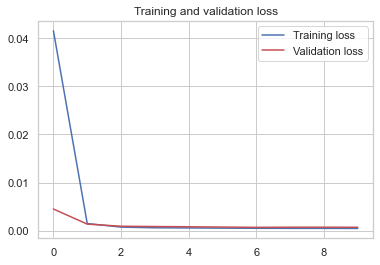

In [13]:
# plotting train and validation loss


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(Epochs)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

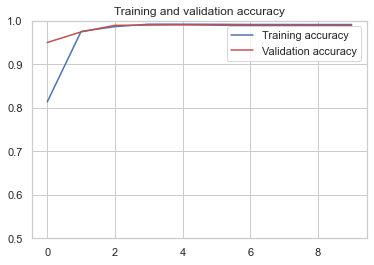

In [14]:
# plotting train and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(Epochs)
plt.figure()
axes=plt.gca()
axes.set_ylim([0.5,1])
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
# Reconstructing data

reconstructions = lstm_model.predict(x_test_transformed)

# reshaping data again from 3D to 2D for finding the average along the column

reconstructions=reconstructions.reshape(-1,x_test_transformed.shape[2])
x_test_transformed=x_test_transformed.reshape(-1,x_test_transformed.shape[2])

mse = np.mean(np.power((reconstructions-x_test_transformed),2), axis=1)


In [16]:
# calculating the modified z-score to find outliers

# manually setting threshold
Threshold = 0.015

def _z_score(mse):
    median_val_mse = np.median(mse)
    diff = np.abs(mse - median_val_mse)
    median_of_diff = np.median(diff)
    
    return 0.6745 * diff/median_of_diff


#z_score = _z_score(mse)

outliers = mse > Threshold

print("There are {} outliers in a total of {} signals.".format(np.sum(outliers), len(mse)))

There are 13563 outliers in a total of 125173 signals.


<function matplotlib.pyplot.show(close=None, block=None)>

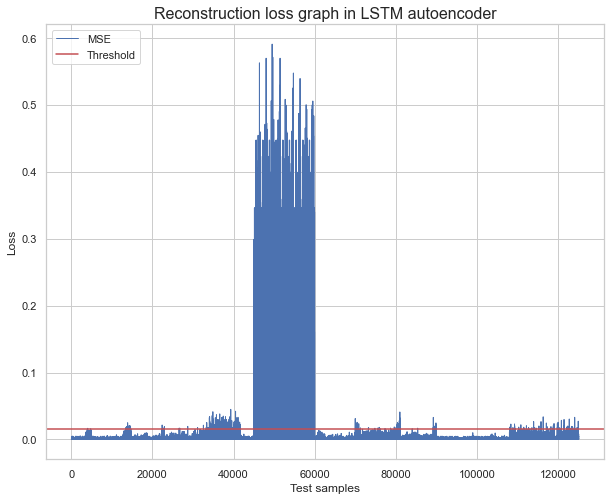

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mse, label='MSE', color='b', linewidth=1)
plt.axhline(Threshold, label='Threshold', color='r', linestyle='-')
plt.legend(loc='upper left')
ax.set_title('Reconstruction loss graph in LSTM autoencoder', fontsize=16)
plt.xlabel('Test samples')
plt.ylabel('Loss')
plt.savefig('lstm_autoencoder.png')
plt.show

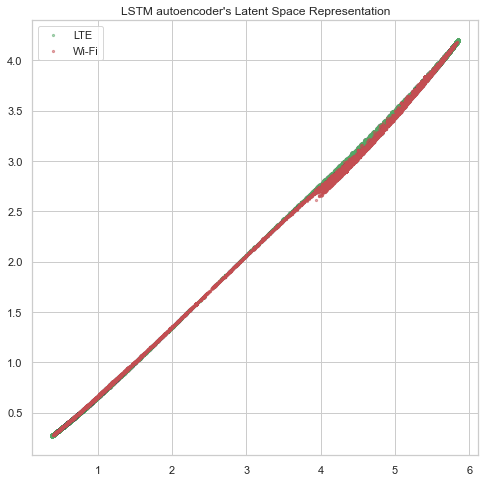

In [18]:
# Visualizing the latent space

encoder = Model(input_layer,latent_vector)

x_temp = x_test_transformed.reshape(x_test_transformed.shape[0],1,x_test_transformed.shape[1])
latent_space = encoder.predict(x_temp)

X = latent_space[:,0]
Y = latent_space[:,1]

plt.subplots(figsize=(8,8))
plt.scatter(X[labels==0],Y[labels==0], s=5, c='g', alpha=0.5, label='LTE')
plt.scatter(X[labels==1],Y[labels==1], s=5, c='r', alpha=0.5, label='Wi-Fi')

plt.legend()
plt.title('LSTM autoencoder\'s Latent Space Representation')

plt.savefig('LSTM autoencoder\'s Latent Space Representation.png')
plt.show()

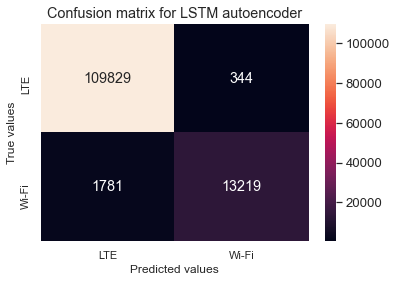

In [19]:
# CONFUSION MATRIX

cm=confusion_matrix(labels,outliers)

ax=plt.subplot()
sns.set(font_scale=1.2)
sns.heatmap(cm,annot=True, fmt='g')

ax.set_xlabel('Predicted values')
ax.set_ylabel('True values')

ax.set_yticklabels(['LTE','Wi-Fi'])
ax.set_xticklabels(['LTE','Wi-Fi'])
ax.set_title('Confusion matrix for LSTM autoencoder')

plt.savefig('conf_matrix_lstm_autoencoder.png')

In [20]:
# Precision, Recall and F1-score

print("Precision of classification:", "%.2f" % (precision_score(labels,outliers)*100),"%")
print("Recall of classification:","%.2f" % (recall_score(labels,outliers)*100),"%")
print("F1-score of classification:","%.2f" % (f1_score(labels,outliers)))

Precision of classification: 97.46 %
Recall of classification: 88.13 %
F1-score of classification: 0.93


# Observations:

# 'elu' activation function is the best for this task

# providing magnitude, phase features along with I/Q data for input performs better compared to current methods